In [82]:
import torch
import re
import nltk
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer, word_tokenize,sent_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from scipy.spatial import distance
from tqdm import tqdm

In [25]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/aproano/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")  

tensor([1.], device='mps:0')


In [6]:
ss = SnowballStemmer('spanish')
sw = stopwords.words('spanish')
tokenizer = RegexpTokenizer(r'\w+')

In [107]:
text = open('./data/gabriel_garcia_marquez_cien_annos_soledad.txt', 'r').read().lower()
#text = open('./data/cap1.txt', 'r').read().lower()

In [108]:
# clean sentences
def clean_data(data):
    
    repl = ''
    # remove non-alphanumeric
    for pattern in set(re.findall(r"[^\w ]", data)):
        repl = ''
        if pattern == '-':
            repl = ' '
        # keep period, apostrophe
        if pattern != '.' and pattern != "\'":
            data = re.sub("\\" + pattern, repl, data)
            
    return data


In [109]:
# sentence tokenization
def split_data(data, num_sentences = -1):

    if num_sentences == -1:
        sentences = sent_tokenize(data)
    else:
        sentences = sent_tokenize(data)[:num_sentences]
    
    # word tokenization
    words = set()
    for sent in sentences:
        for word in str.split(sent,' '):
            words.add(word)
    words=list(words)
    
    # add empty string in list of words. During padding 0s can be interpreted as empty string
    words.insert(0,"")

    return sentences, words

In [110]:
data = clean_data(text)

In [111]:
sentences, words = split_data(data)

In [112]:
sentences[:3]

['gabriel garcía márquez cien años de soledad editado por ediciones la cueva para j omi garcía ascot y maría luisa elio cien años de soledad gabriel garcía márquez muchos años después frente al pelotón de fusilamiento el coronel aureliano buendía había de recordar aquella tarde remota en que su padre lo llevó a conocer el hielo.',
 'macondo era entonces una aldea de veinte casas de barro y cañabrava construidas a la orilla de un río de aguas diáfanas que se precipitaban por un lecho de piedras pulidas blancas y enormes como huevos prehistóricos.',
 'el mundo era tan reciente que muchas cosas carecían de nombre y para mencionarlas había que señalarías con el dedo.']

In [113]:
words[:10]

['',
 '',
 'meses.',
 'cadencia',
 'desnuda.',
 'vagaba',
 'pagando',
 'cuarteado',
 'varias',
 'ventruda']

In [114]:
sent_sequences = []
seq_len = 6
for i in range(len(sentences)):
    words_in_sent = str.split(sentences[i],' ')
    for j in range(1,len(words_in_sent)):
        if j <= (seq_len):
            sent_sequences.append(words_in_sent[:j])
        elif j > seq_len and j < len(words_in_sent):
            sent_sequences.append(words_in_sent[j - seq_len:j])
        elif j > len(words_in_sent) - seq_len:
            sent_sequences.append(words_in_sent[j - seq_len:])

In [115]:
sent_sequences[:6]

[['gabriel'],
 ['gabriel', 'garcía'],
 ['gabriel', 'garcía', 'márquez'],
 ['gabriel', 'garcía', 'márquez', 'cien'],
 ['gabriel', 'garcía', 'márquez', 'cien', 'años'],
 ['gabriel', 'garcía', 'márquez', 'cien', 'años', 'de']]

In [116]:
predictors = []
class_labels = []
for i in range(len(sent_sequences)):
    predictors.append(sent_sequences[i][:-1])
    class_labels.append(sent_sequences[i][-1])

In [117]:
predictors[:7]

[[],
 ['gabriel'],
 ['gabriel', 'garcía'],
 ['gabriel', 'garcía', 'márquez'],
 ['gabriel', 'garcía', 'márquez', 'cien'],
 ['gabriel', 'garcía', 'márquez', 'cien', 'años'],
 ['garcía', 'márquez', 'cien', 'años', 'de']]

In [118]:
class_labels[:7]

['gabriel', 'garcía', 'márquez', 'cien', 'años', 'de', 'soledad']

In [119]:
pad_predictors = []
for i in range(len(predictors)):
    emptypad = [''] * (seq_len - len(predictors[i]) - 1)
    emptypad.extend(predictors[i])
    pad_predictors.append(emptypad)

In [120]:
pad_predictors[:7]

[['', '', '', '', ''],
 ['', '', '', '', 'gabriel'],
 ['', '', '', 'gabriel', 'garcía'],
 ['', '', 'gabriel', 'garcía', 'márquez'],
 ['', 'gabriel', 'garcía', 'márquez', 'cien'],
 ['gabriel', 'garcía', 'márquez', 'cien', 'años'],
 ['garcía', 'márquez', 'cien', 'años', 'de']]

In [121]:
ttoi = {token:idx for idx,token in enumerate(words)}
itot = {idx:token for token,idx in ttoi.items()}

In [122]:
for i in range(len(pad_predictors)):
    for j in range(len(pad_predictors[i])):
        pad_predictors[i][j] = ttoi[pad_predictors[i][j]]
    class_labels[i] = ttoi[class_labels[i]]

In [123]:
pad_predictors[:7]

[[1, 1, 1, 1, 1],
 [1, 1, 1, 1, 4318],
 [1, 1, 1, 4318, 6375],
 [1, 1, 4318, 6375, 16914],
 [1, 4318, 6375, 16914, 12029],
 [4318, 6375, 16914, 12029, 10148],
 [6375, 16914, 12029, 10148, 12967]]

In [124]:
class_labels[:7]

[4318, 6375, 16914, 12029, 10148, 12967, 3686]

In [125]:
for i in range(len(pad_predictors)):
    pad_predictors[i]=torch.tensor(pad_predictors[i])
pad_predictors=torch.stack(pad_predictors)
class_labels=torch.tensor(class_labels)

In [126]:
pad_predictors[:7]

tensor([[    1,     1,     1,     1,     1],
        [    1,     1,     1,     1,  4318],
        [    1,     1,     1,  4318,  6375],
        [    1,     1,  4318,  6375, 16914],
        [    1,  4318,  6375, 16914, 12029],
        [ 4318,  6375, 16914, 12029, 10148],
        [ 6375, 16914, 12029, 10148, 12967]])

In [127]:
class_labels[:7]

tensor([ 4318,  6375, 16914, 12029, 10148, 12967,  3686])

In [128]:
# make the data numbers
def encode_data(sentences, words, seq_len):
    
    sent_sequences = []
    for i in range(len(sentences)):
        words_in_sent = str.split(sentences[i],' ')
        for j in range(1,len(words_in_sent)):
            if j <= (seq_len):
                sent_sequences.append(words_in_sent[:j])
            elif j > seq_len and j < len(words_in_sent):
                sent_sequences.append(words_in_sent[j-seq_len:j])
            elif j > len(words_in_sent)-seq_len:
                sent_sequences.append(words_in_sent[j-seq_len:])
                

    # split into predictors and class_labels
    predictors = []
    class_labels = []
    for i in range(len(sent_sequences)):
        predictors.append(sent_sequences[i][:-1])
        class_labels.append(sent_sequences[i][-1])
    
    # pad the predictors manually with Empty strings
    pad_predictors = []
    for i in range(len(predictors)):
        emptypad = ['']*(seq_len-len(predictors[i])-1)
        emptypad.extend(predictors[i])
        pad_predictors.append(emptypad)
        
    # tokens to index, and index to tokens
    global ttoi
    ttoi = {token:idx for idx,token in enumerate(words)}
    global itot
    itot = {idx:token for token,idx in ttoi.items()}
        
    # convert each word into their respective index
    for i in range(len(pad_predictors)):
        for j in range(len(pad_predictors[i])):
            pad_predictors[i][j] = word_ind[pad_predictors[i][j]]
        class_labels[i] =  word_ind[class_labels[i]]

    # convert sequences to tensors
    for i in range(len(pad_predictors)):
        pad_predictors[i] = torch.tensor(pad_predictors[i])
    pad_predictors = torch.stack(pad_predictors)
    class_labels = torch.tensor(class_labels)
     
    return pad_predictors, class_labels

In [129]:
class LSTM(nn.Module):
    def __init__(self,num_embeddings, embedding_dim, padding_idx, hidden_size, batch_size):
        super(LSTM,self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx = 0)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers = 1, batch_first = True)
        self.expand = nn.Linear(hidden_size, num_embeddings)

    def init_hidden(self, batch_size):        
        state_h = torch.zeros(1, batch_size, self.hidden_size)
        state_c = torch.zeros(1, batch_size, self.hidden_size)
        return (state_h,state_c)

    def forward(self,input_sequence, state_h,state_c):
        
        embeds = self.embedding(input_sequence)
        output,(state_h,state_c) = self.lstm(embeds, (state_h,state_c))
        logits = self.expand(output[:,-1,:])
         
        return logits,(state_h,state_c)

    def topk_sampling(self, logits, topk):
        
        logits_softmax = torch.nn.functional.softmax(logits,dim = 1)
        values,indices = torch.topk(logits_softmax[0],k = topk)
        choices = indices.tolist()
        sampling = random.sample(choices,1)
        
        return itot[sampling[0]]
        

In [141]:
# generate sentences
def generate_sent(model, init, sent_len, topk):

    sentence=init
    for k in range(sent_len):
        model.eval()
        input_indices = []
        for word in str.split(sentence," "):
            input_indices.append(ttoi[word])
        if len(input_indices) < seq_len - 1:
            input_tensor = [0] * (seq_len - len(input_indices) - 1)
            input_tensor.extend(input_indices)
        else:
            input_tensor = input_indices[-seq_len + 1:]
            
        state_h,state_c = model.init_hidden(len(input_tensor))
        input_tensor = torch.stack([torch.tensor(input_tensor)])
        out,(state_h,state_c) = model(input_tensor.transpose(0,1), state_h, state_c)
        
        word=model.topk_sampling(out, topk)
        
        if word != '' and word != str.split(sentence,' ')[-1]:
            sentence += " " + word

    return sentence

In [131]:
def get_batch(pad_predictors, class_labels, batch_size):
    for i in range(0, len(pad_predictors), batch_size):
        if i + batch_size < len(pad_predictors):
            yield pad_predictors[i : i + batch_size], class_labels[i : i + batch_size]

In [132]:
model = LSTM(len(words), embedding_dim=1, padding_idx=0, hidden_size=128, batch_size=64)

In [133]:
LR = 3e-3
EPOCHS = 20
batch_size=64
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [135]:
progress_bar = tqdm(range(EPOCHS * len(pad_predictors)))
running_loss = []

for epoch in range(EPOCHS):
    state_h, state_c=model.init_hidden(batch_size)
    total_loss = 0
    for x, y in get_batch(pad_predictors, class_labels, batch_size):
        
        model.train()
            
        state_h=state_h.detach()
        state_c=state_c.detach()
        logits,(state_h,state_c)=model(x, state_h, state_c)
        
        optimizer.zero_grad()
        loss = criterion(logits, y)
        loss_value = loss.item()
        total_loss += len(x) * loss_value
        loss.backward()
        
        optimizer.step()
    
    progress_bar.update()    
    total_loss /= len(pad_predictors)
    running_loss.append(total_loss)

  0%|                                                                         | 20/2699560 [05:22<12132:53:17, 16.18s/it]

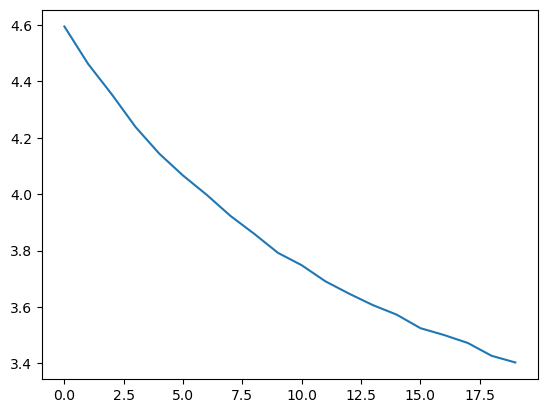

In [157]:
plt.plot(running_loss)

In [155]:
generate_sent(model, init='casa en macondo', sent_len=10, topk=25)

'casa en macondo una los en tres haciendo corazón guerra que guerra'

In [164]:
generate_sent(model, init='amaranta hace', sent_len=10, topk=25)

'amaranta hace al en un con quedar coronel comer primer febrero'